In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

In [69]:
def fix_image_to_show(img):
    image = img.copy()
    image = image.astype('float32')
    max_pixel = np.max(image)
    min_pixel = np.min(image)
    if max_pixel == min_pixel:
        image[:, :, :] = 127
        image = image.astype('uint8')
        return image
    m = 255 / (max_pixel - min_pixel)
    image = image * m - min_pixel * m
    image = image.astype('uint8')
    return image

def show_image(img, name=None, cmap=None):
    image = img.copy()
    image = fix_image_to_show(image)
    plt.imshow(image, vmin=0, vmax=255, cmap=cmap)
    plt.show()
    if name is not None :
        plt.imsave(name + '.jpg', image, cmap=cmap)

In [5]:
image1 = cv2.imread('resources/01.JPG')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread('resources/02.JPG')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image1_org = image1.copy()
image2_org = image2.copy()

In [6]:
sift = cv2.SIFT_create()

kp1, desc1 = sift.detectAndCompute(image1, None)
kp2, desc2 = sift.detectAndCompute(image2, None)

bf_matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf_matcher.match(desc1, desc2)

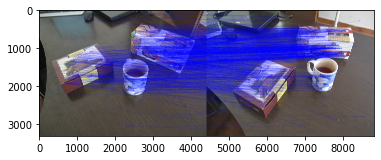

In [11]:
image1_matches = [kp1[o.queryIdx] for o in matches]
image2_matches = [kp2[o.trainIdx] for o in matches]

keypoints_image1 = cv2.drawKeypoints(image1.copy(), kp1, image1.copy(), color=(0, 255, 0))
keypoints_image2 = cv2.drawKeypoints(image2.copy(), kp2, image2.copy(), color=(0, 255, 0))

matched_image = cv2.drawMatches(image1, kp1, image2, kp2, matches, keypoints_image1, flags=2, matchColor=(0, 0, 255))
show_image(matched_image)


In [75]:
image1_pt = []
image2_pt = []
for kp in image1_matches:
    image1_pt.append(kp.pt)
    
for kp in image2_matches:
    image2_pt.append(kp.pt)
image1_pt = np.int32(image1_pt)
image2_pt = np.int32(image2_pt)
F, mask = cv2.findFundamentalMat(image1_pt, image2_pt, cv2.FM_LMEDS)
print(F)

[[-2.90186246e-09 -6.59211598e-08 -1.80342884e-04]
 [-8.55482083e-08 -7.26821199e-09 -1.46761374e-03]
 [-1.52795397e-04  1.80859296e-03  1.00000000e+00]]


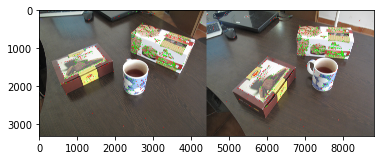

In [109]:
image1 = image1_org.copy()
image2 = image2_org.copy()
for i in range(len(image1_pt)): 
    pt = image1_pt[i]
    color = (255, 0, 0)
    if mask[i, 0] == 1: 
        color = (0, 255, 0)
    cv2.circle(image1, (pt[0], pt[1]), radius=2, thickness=10, color=color)
    
for i in range(len(image2_pt)): 
    pt = image2_pt[i]
    color = (255, 0, 0)
    if mask[i, 0] == 1: 
        color = (0, 255, 0)
    cv2.circle(image2, (pt[0], pt[1]), radius=2, thickness=10, color=color)
con_image = np.concatenate((image1, image2), axis=1)
show_image(con_image, 'res05')

In [86]:
image1 = image1_org.copy()
image2 = image2_org.copy()

def solve(A):
    import numpy.linalg.linalg as linalg
    u, s, v = linalg.svd(A)
    res = v[2, :]
    
    return (math.floor(res[0] / res[2]), math.floor(res[1] / res[2]))

e1 = solve(F)
print(e1)

e2 = solve(np.transpose(F))
print(e2)

(-16987, -1988)
(27736, -2727)


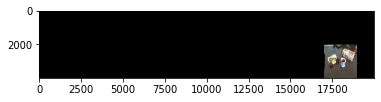

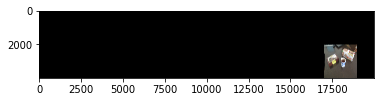

In [100]:
image1 = image1_org.copy()
image1 = cv2.resize(image1, (2000, 2000))

translation_mat = np.asarray([
        [1, 0, -e1[0] + 20],
        [0, 1, -e1[1] + 20],
        [0, 0, 1],
    ], dtype='float32'
)

res6 = cv2.warpPerspective(image1, translation_mat, (20000, 4000))
cv2.circle(res6, (20, 20), radius=10, color=(255, 0, 0), thickness=100)
plt.imshow(res6)
plt.show()
plt.imsave('res06.jpg', res6)

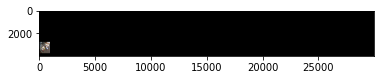

In [103]:
image2 = image2_org.copy()
image2 = cv2.resize(image2, (1000, 1000))

translation_mat = np.asarray([
        [1, 0, 20],
        [0, 1, -e2[1] + 20],
        [0, 0, 1],
    ], dtype='float32'
)

res7 = cv2.warpPerspective(image2, translation_mat, (30000, 4000))
cv2.circle(res7, (20, -e2[1] + 20), radius=10, color=(255, 0, 0), thickness=100)
plt.imshow(res7)
plt.show()
plt.imsave('res07.jpg', res7)

In [104]:
del(res6)
del(res7)

(-16987, -1988)


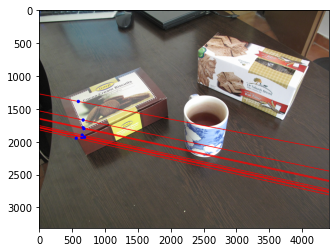

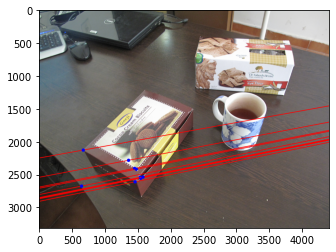

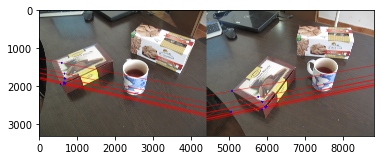

In [146]:
print(e1)
image1 = image1_org.copy()
image2 = image2_org.copy()
cnt = 0
res81 = image1.copy()
res82 = image2.copy()
for i in range(len(image1_pt)): 
    pt = image1_pt[i]
    if mask[i, 0] == 0 or cnt == 10:
        continue
    cnt = cnt + 1
    x = np.asarray(
        [[pt[0]], [pt[1]], [1]], dtype='float32'
    )
    h = np.matmul(F, x)
    
    pt1 = (e1[0], e1[1])
    
    m = (pt1[1] - pt[1]) / (pt1[0] - pt[0])
    b = e1[1] - m * e1[0]
    
    cv2.line(res81, pt1, (30000, math.floor(30000 * m + b)), (255, 0, 0), 10)
    cv2.circle(res81, (pt[0], pt[1]), radius=10, thickness=30, color=(0, 0, 255))



cnt = 0
for i in range(len(image2_pt)): 
    pt = image2_pt[i]
    if mask[i, 0] == 0 or cnt == 10:
        continue
    cnt = cnt + 1
    x = np.asarray(
        [[pt[0]], [pt[1]], [1]], dtype='float32'
    )
    h = np.matmul(np.transpose(F), x)
    
    pt1 = (e2[0], e2[1])
    m = (pt[1] - pt1[1]) / (pt[0] - pt1[0])
    b = e2[1] - m * e2[0]
    
    
    cv2.line(res82, e2, (-10000, math.floor(m * -10000 + b)), (255, 0, 0), 10)
    cv2.circle(res82, (pt[0], pt[1]), radius=10, thickness=30, color=(0, 0, 255))

    
show_image(res81)  
show_image(res82)  
res8 = np.concatenate((res81, res82), axis=1)
show_image(res8, 'res08')